# Load Data

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 939 kB 4.2 MB/s 
     |████████████████████████████████| 251 kB 60.2 MB/s 


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"

project_folder = "FYP/MONAI_Lung/"
data_loc = "FYP/MONAI_Lung/Data/Task06_Lung/"

data_dir = root_dir + data_loc


def create_and_set_working_directory(project_folder):
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  os.chdir(root_dir + project_folder)
  print('\nYour working directory was changed to ' + root_dir + project_folder)

create_and_set_working_directory(project_folder)

Mounted at /content/drive

Your working directory was changed to /content/drive/My Drive/FYP/MONAI_Lung/


In [ ]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(keys=["image", "label"], pixdim=(
        #     1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-157, a_max=164,
        #     b_min=0.0, b_max=1.0, clip=True,
        # ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(keys=["image", "label"], pixdim=(
        #     1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-150, a_max=0,
        #     b_min=0.0, b_max=1.0, clip=True,
        # ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:19<00:00,  2.14s/it]


# Define Model

In [ ]:
from typing import Optional, Sequence, Tuple, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, deprecated_arg, export

class TestNet(nn.Module):
    
    def __init__(self):
        super(TestNet, self).__init__()

        channels = [32,64,128,192,256,384,512,768,1024,2048]
        self.down1 = Convolution(3, 1, channels[0], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down2 = Convolution(3, channels[0], channels[1], strides=2, kernel_size=7, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down3 = Convolution(3, channels[1], channels[2], strides=2, kernel_size=5, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down4 = Convolution(3, channels[2], channels[3], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down5 = Convolution(3, channels[3], channels[4], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down6 = Convolution(3, channels[4], channels[5], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down7 = Convolution(3, channels[5], channels[6], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down8 = Convolution(3, channels[6], channels[7], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down9 = Convolution(3, channels[7], channels[8], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down10 = Convolution(3, channels[8], channels[9], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)

        self.up10 = Convolution(3, channels[9], channels[8], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up9 = Convolution(3, channels[8], channels[7], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up8 = Convolution(3, channels[7], channels[6], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up7 = Convolution(3, channels[6], channels[5], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up6 = Convolution(3, channels[5], channels[4], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up5 = Convolution(3, channels[4], channels[3], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up4 = Convolution(3, channels[3], channels[2], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up3 = Convolution(3, channels[2], channels[1], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up2 = Convolution(3, channels[1], channels[0], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)

        self.res10 = Convolution(3, 2*channels[8], channels[8], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res9 = Convolution(3, 2*channels[7], channels[7], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res8 = Convolution(3, 2*channels[6], channels[6], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res7 = Convolution(3, 2*channels[5], channels[5], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res6 = Convolution(3, 2*channels[4], channels[4], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res5 = Convolution(3, 2*channels[3], channels[3], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res4 = Convolution(3, 2*channels[2], channels[2], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res3 = Convolution(3, 2*channels[1], channels[1], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res2 = Convolution(3, 2*channels[0], channels[0], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=True, is_transposed=True)
        self.res1 = Convolution(3, channels[0], 2, strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=True, is_transposed=True)

        self.up1 = Convolution(3, channels[0], 2, strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)

    def forward(self, x):

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u5 = self.up5(d5)
        skip5 = self.res5(torch.cat([u5,d4],dim=1))
        u4 = self.up4(skip5)
        skip4 = self.res4(torch.cat([u4,d3],dim=1))
        u3 = self.up3(skip4)
        skip3 = self.res3(torch.cat([u3,d2],dim=1))
        u2 = self.up2(skip3)
        skip2 = self.res2(torch.cat([u2,d1],dim=1))
        output = self.up1(skip2)

        return output

device = torch.device("cuda:0")

model = TestNet()

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Check slices

image shape: torch.Size([512, 386, 450]), label shape: torch.Size([512, 386, 450])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


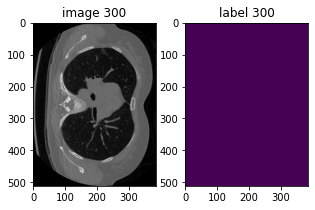

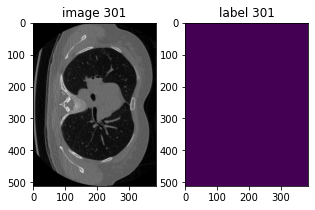

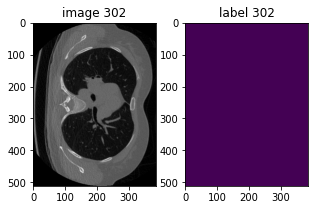

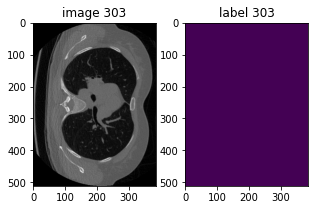

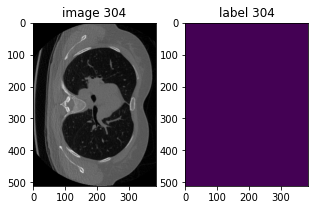

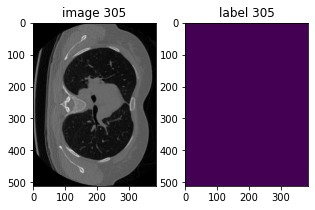

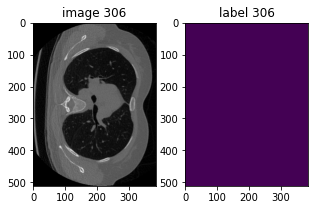

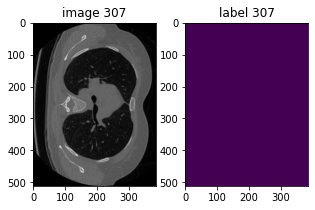

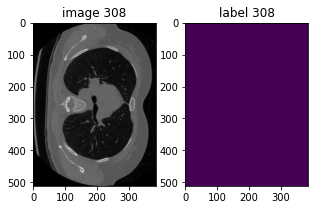

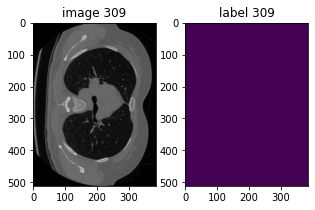

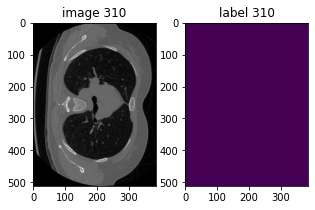

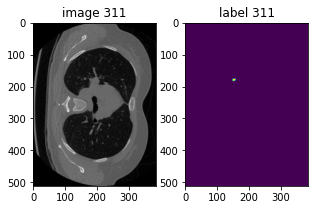

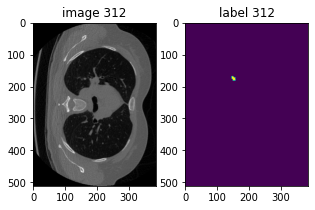

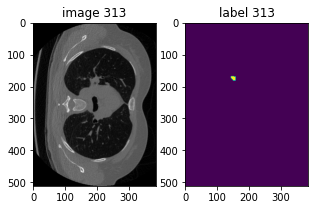

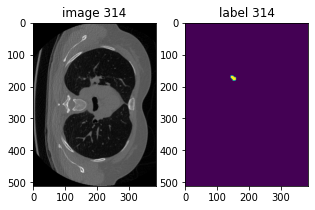

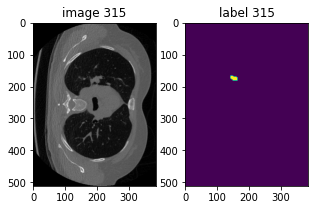

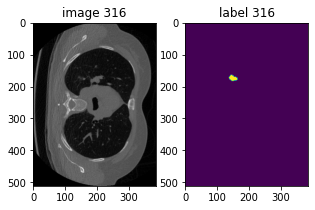

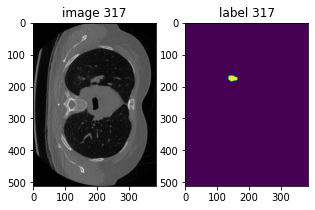

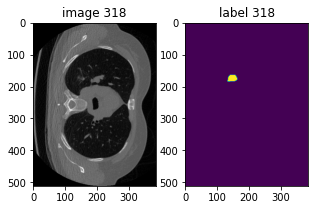

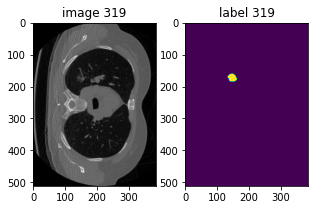

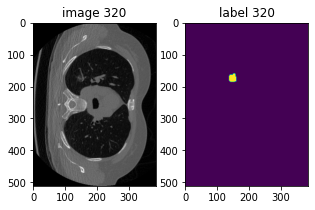

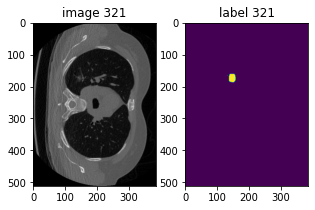

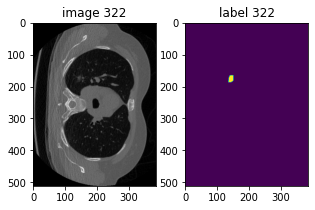

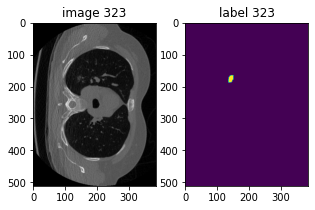

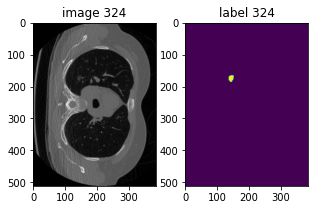

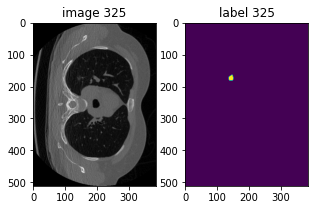

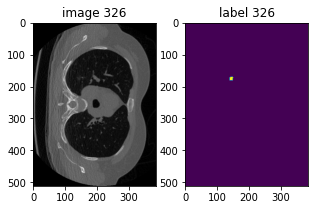

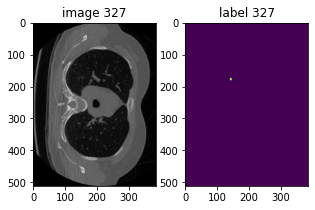

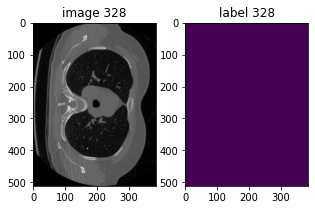

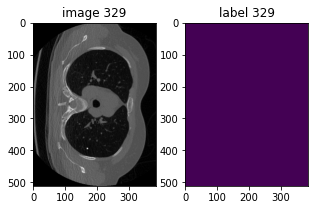

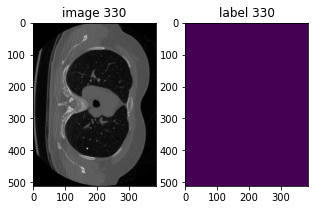

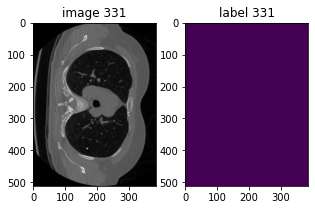

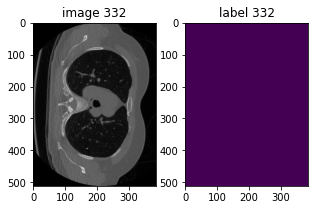

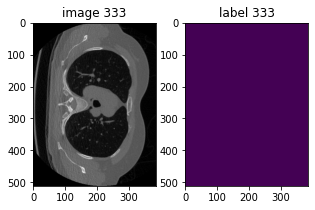

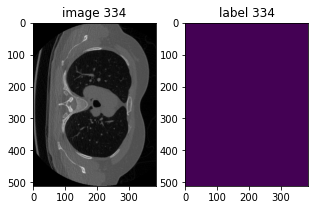

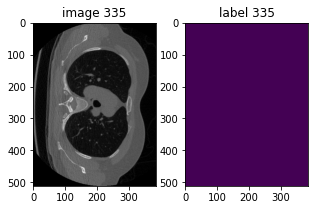

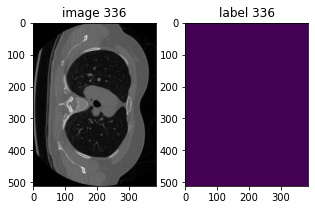

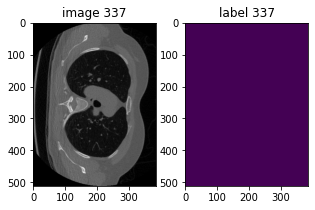

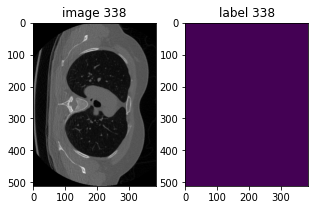

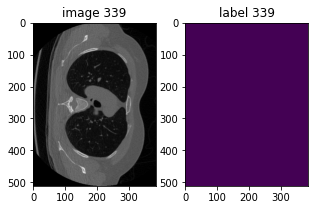

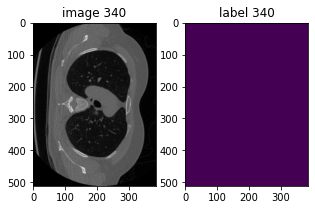

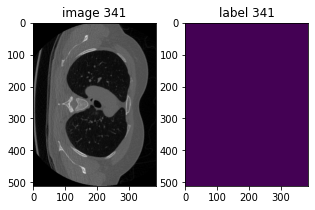

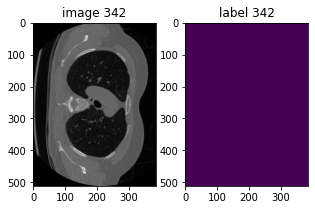

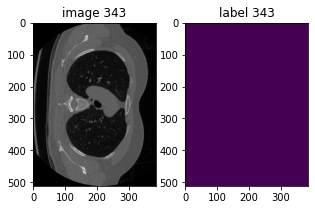

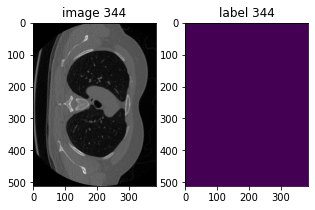

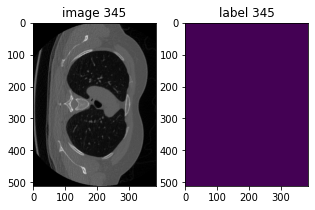

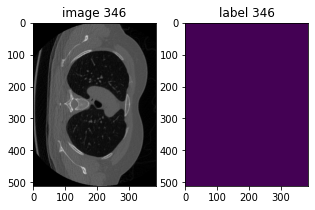

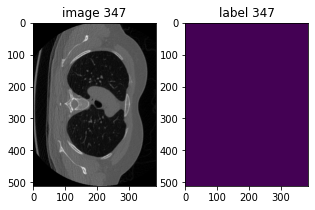

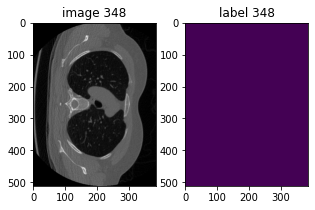

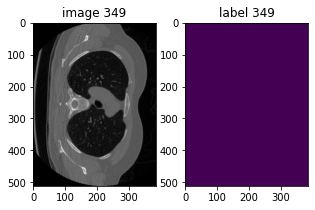

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 120]
for i in range(300,350):
  plt.figure(figsize=(5, 3))
  plt.subplot(1, 2, 1)
  plt.title("image " + str(i))
  plt.imshow(image[:, :, i], cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label " + str(i))
  plt.imshow(label[:, :, i])
plt.show()

# Load and Evaluate Model

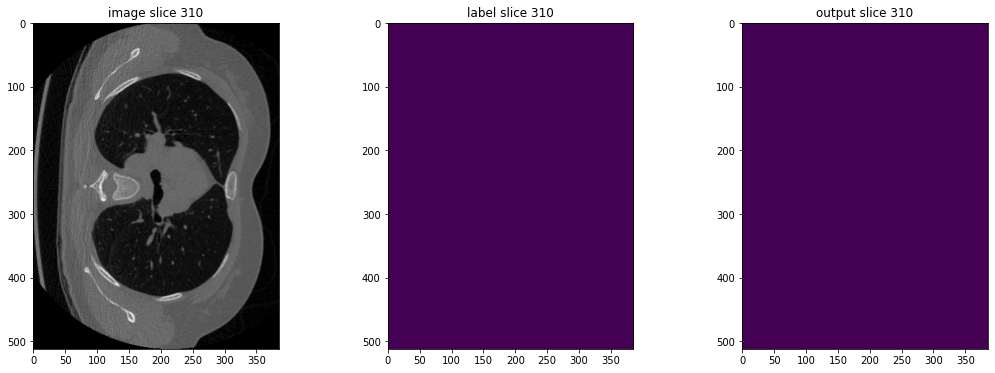

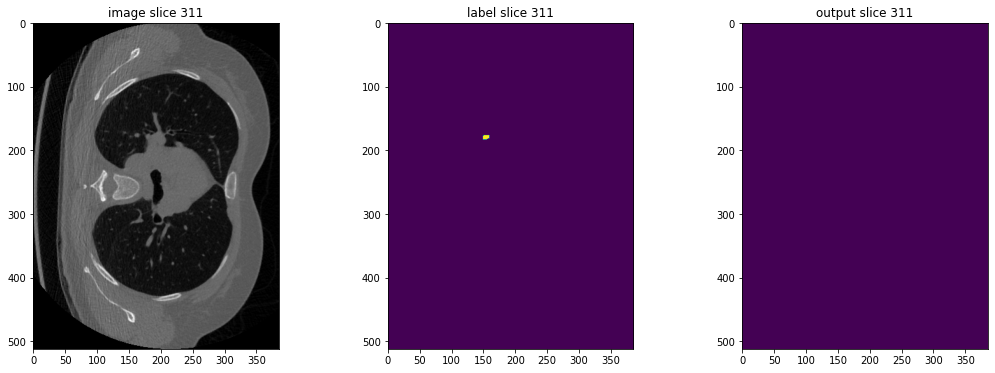

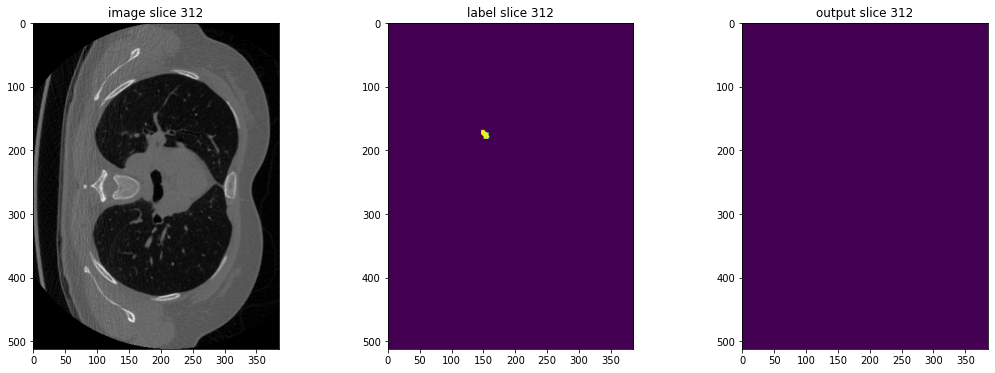

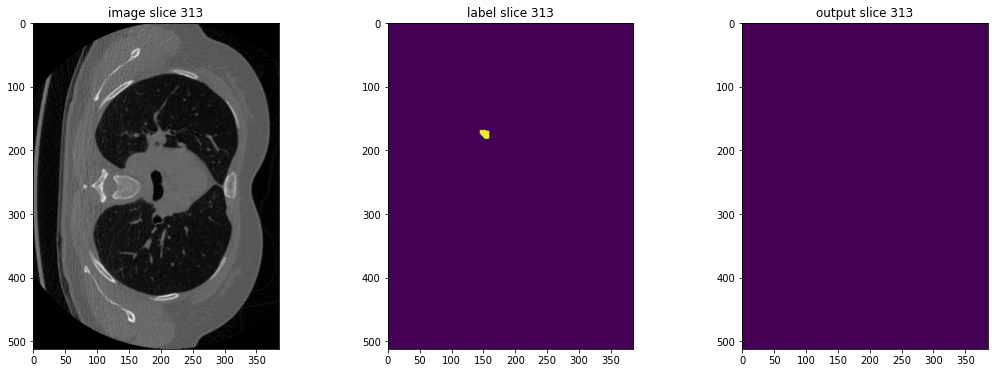

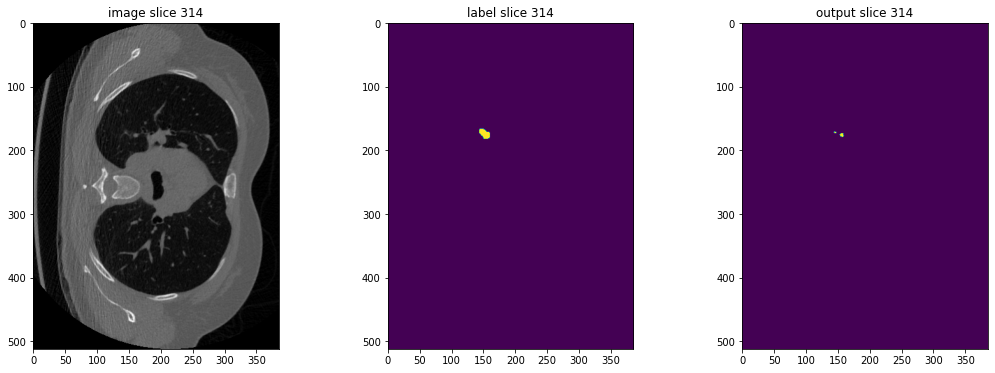

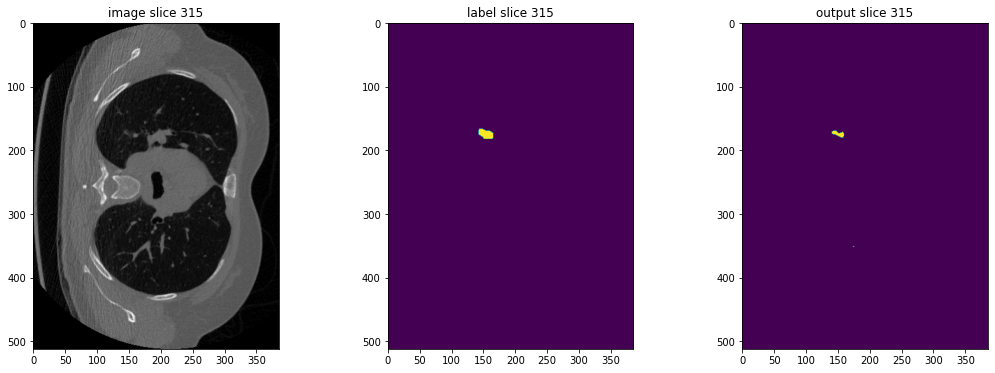

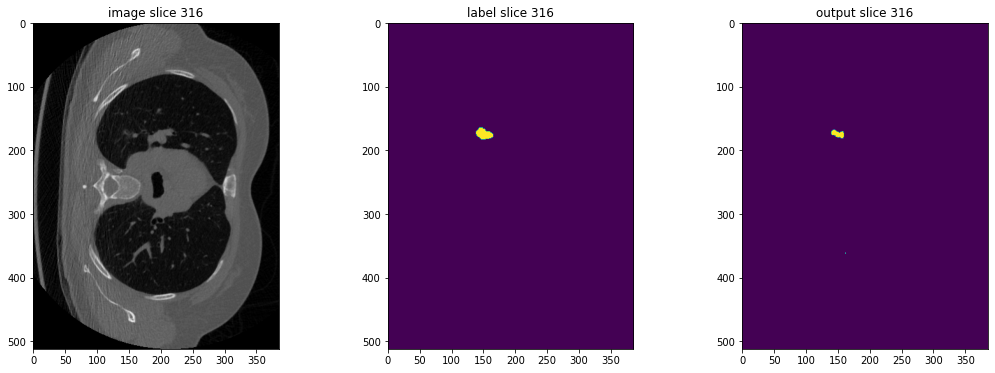

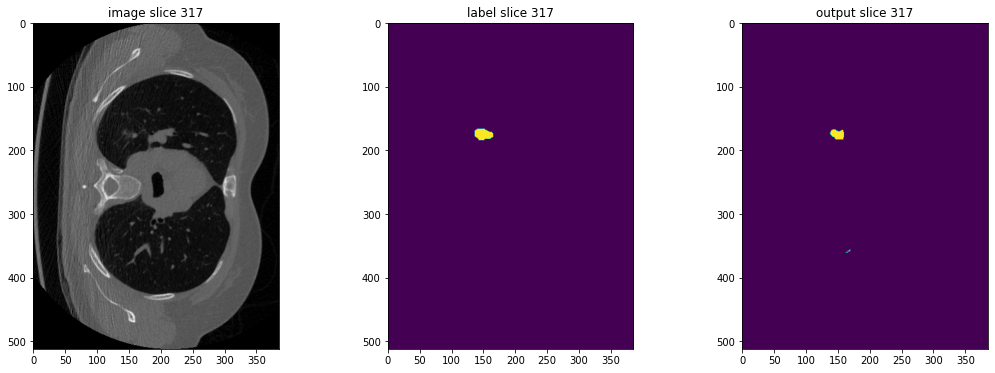

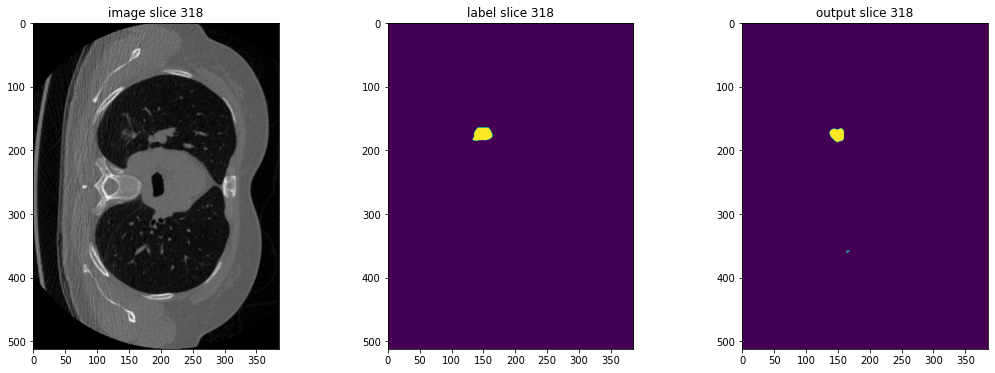

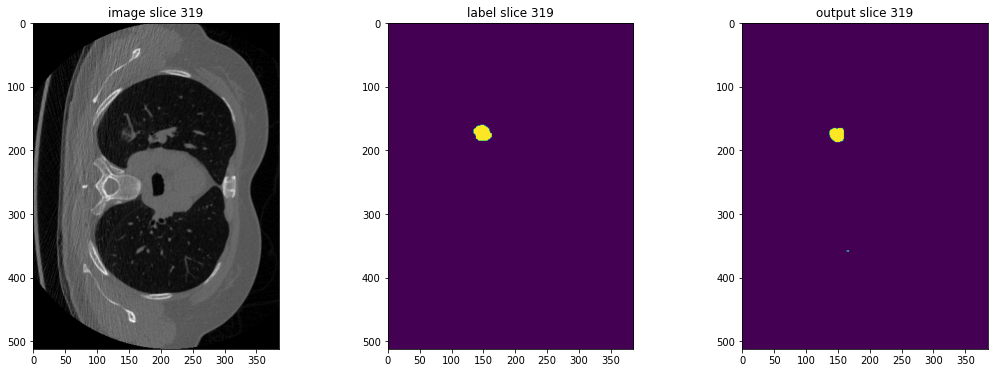

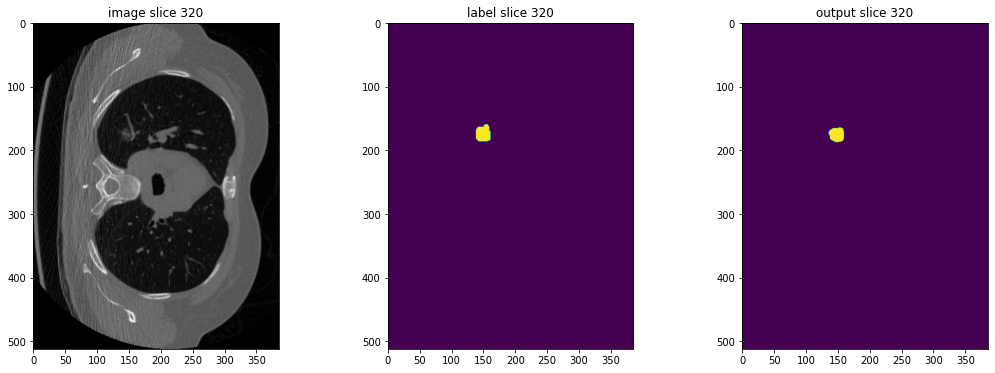

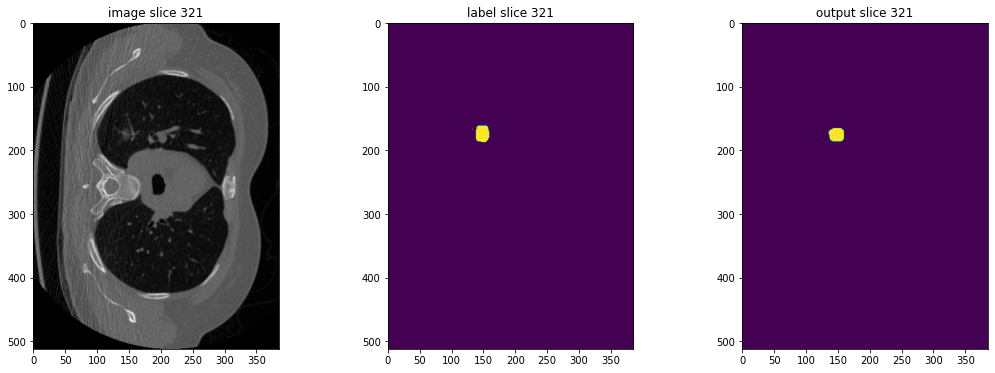

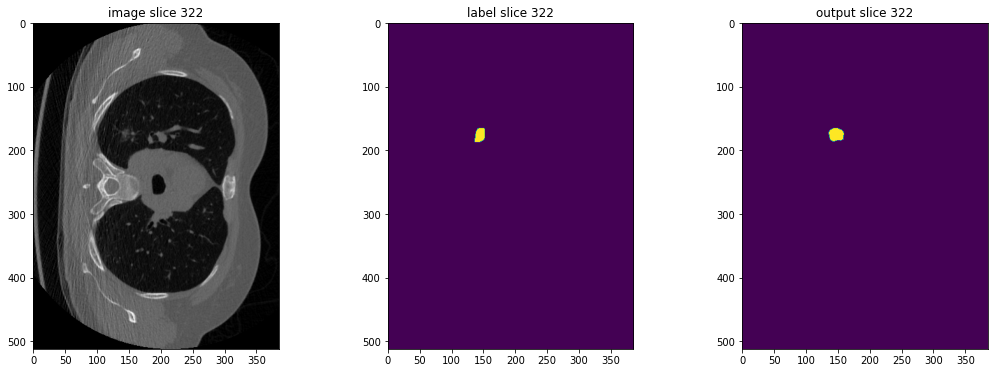

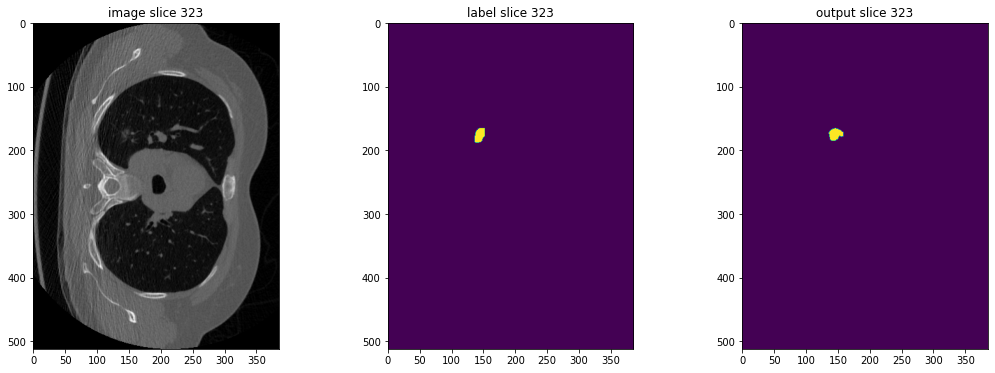

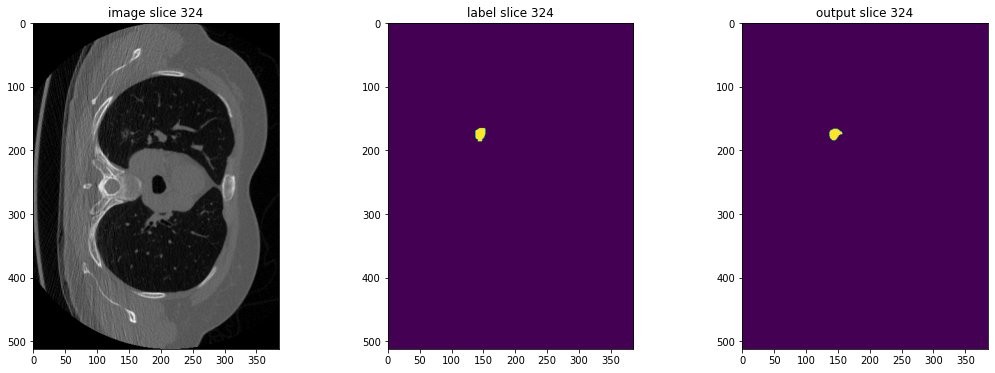

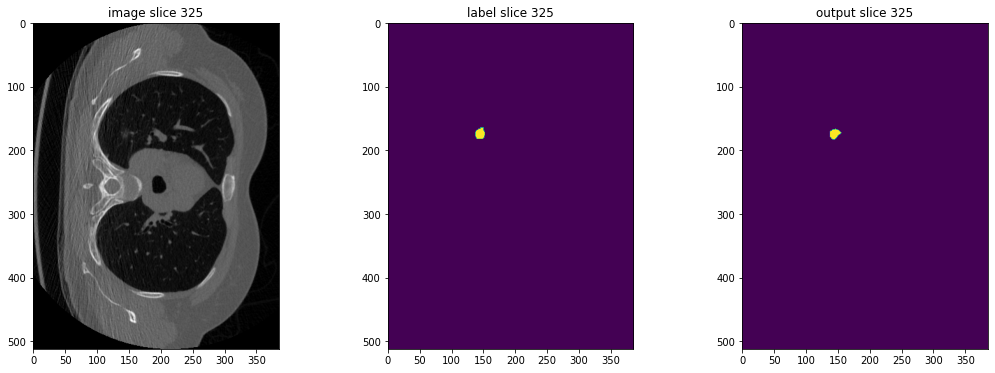

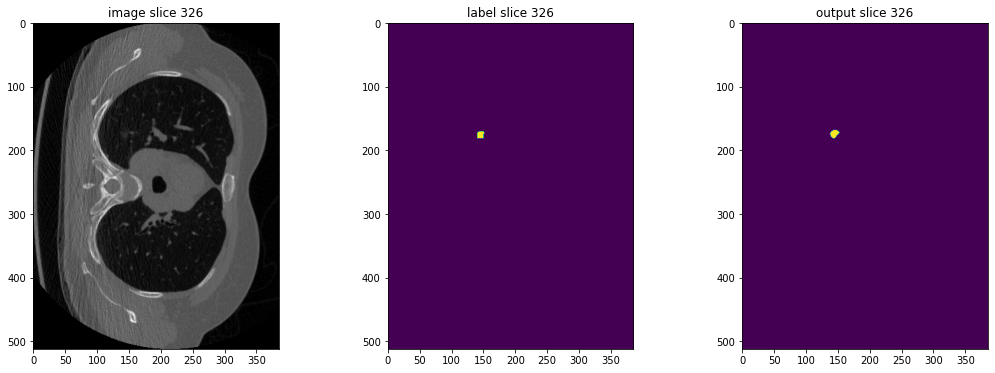

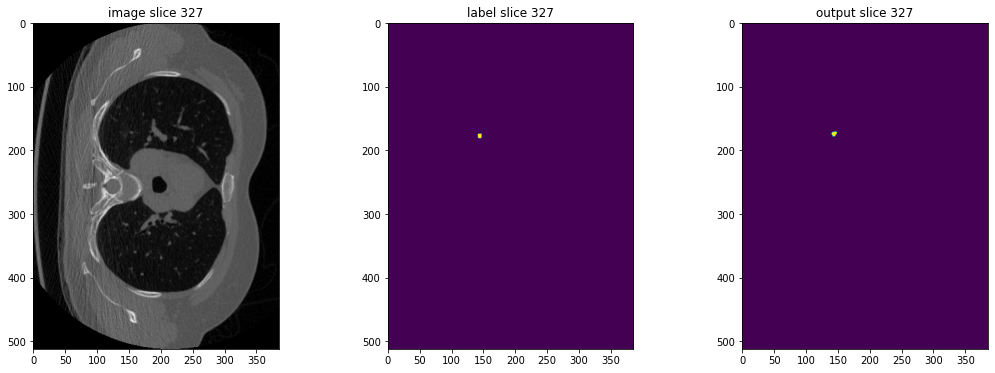

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_UNet_trial_1.pth")))

model = model.to(device)
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot tumour slices (finding them first)
        for j in range(310,328):
          plt.figure("check", (18, 6))
          plt.subplot(1, 3, 1)
          plt.title(f"image slice {j}")
          plt.imshow(val_data["image"][0, 0, :, :, j], cmap="gray")
          plt.subplot(1, 3, 2)
          plt.title(f"label slice {j}")
          plt.imshow(val_data["label"][0, 0, :, :, j])
          plt.subplot(1, 3, 3)
          plt.title(f"output slice {j}")
          plt.imshow(torch.argmax(
              val_outputs, dim=1).detach().cpu()[0, :, :, j])
          plt.show()
        break

In [ ]:
root_dir = "/content/drive/My Drive/"
project_folder = "FYP/MONAI_Lung/"

import pandas as pd  
  
     
# list of name, degree, score 
epoch_loss_values = [0.0,0.1,0.2,0.3] 
epoch_full_res_loss_values = [0.1,0.2,0.3,0.4]
epoch_res_1_loss_values = [0.2,0.3,0.4,0.5]
epoch_res_2_loss_values = [0.3,0.4,0.5,0.6]
epoch_res_3_loss_values = [0.4,0.5,0.6,0.7]
epoch_res_4_loss_values = [0.5,0.6,0.7,0.8]
     
# dictionary of lists  
dict = {'total loss': epoch_loss_values, 'full res': epoch_full_res_loss_values, '1/2 res': epoch_res_1_loss_values, 
        '1/4 res': epoch_res_2_loss_values, '1/8 res': epoch_res_3_loss_values, '1/16 res': epoch_res_4_loss_values}  
df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv(root_dir+project_folder+"test.csv") 